# Imports

In [2]:
# Imports
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
import os
import pandas as pd
import h5py

# Plot settings
plt.rcParams.update({
    'axes.titlesize': 11,
    'axes.labelsize': 11,
    'xtick.labelsize': 11,
    'ytick.labelsize': 11,
    'lines.linewidth': 0.8
})

# Flags
figs_only = False
load_data = True
load_soprops = True
intermediate_plots = False


so_prop_dir = data_root #os.path.join(matlab_files_dir, 'so_prop')

# Ensure output directories exist
os.makedirs(matlab_files_dir, exist_ok=True)
os.makedirs(so_prop_dir, exist_ok=True)


In [3]:
# Load parcels (CSV expected to have a single column of 10242 values)
parc = pd.read_csv('cybershuttle_data/bazhlab-whole-brain/sim_files/parcels.csv', header=None).values.flatten()

# Get indices of non-medial wall (non-zero values)
idx = np.arange(1, 10243)  # MATLAB 1-based index range
idx_ml = np.where(parc == 0)[0]
idx_nml = np.setdiff1d(idx, idx_ml + 1) - 1  # shift to 0-based
n_nml = len(idx_nml)

# Load surface structure
surf_data = sio.loadmat('/Users/gkrishnan46/Downloads/whole-brain-SO-simulation/analysis/files/ico5_pial_surf_lh.mat', struct_as_record=False, squeeze_me=True)
srf = surf_data['srf']


In [4]:
# Choose one or more folders to process
folders = ['/Users/gkrishnan46/Downloads/whole-brain-SO-simulation/']  # You can modify this to include multiple folders

# Duration of interest
td = 30000  # in milliseconds
time_vector = np.linspace(0, td, td)

In [5]:
#data = sio.loadmat('/Users/gkrishnan46/Downloads/whole-brain-SO-simulation/sim_files/time_cx_SO_base.mat')
so_props = sio.loadmat('/Users/gkrishnan46/Downloads/whole-brain-SO-simulation/sim_files/so_SO_base.mat')

In [6]:
with h5py.File('/Users/gkrishnan46/Downloads/whole-brain-SO-simulation/sim_files/time_cx_SO_base.mat', 'r') as f:
    data = {key: np.array(f[key]) for key in f.keys()}
time_cx = data['time_cx']

In [9]:
# Remove medial wall
time_cx_nml = time_cx[:, idx_nml].T

# Compute average voltage
time_cx_mean = np.nanmean(time_cx_nml, axis=0)
print("Mean voltage shape:", time_cx_mean.shape)

# --- SO peak/min detection ---
from scipy.signal import find_peaks

prominence = (np.nanmax(time_cx_mean) - np.nanmin(time_cx_mean)) / 2
pksep = 500  # min separation in samples

peaks_idx, _ = find_peaks(time_cx_mean, prominence=max(1, prominence), distance=pksep)
peaks = time_cx_mean[peaks_idx]
npeaks = len(peaks)

# Find local minima between peaks
mins = []
locs_mins = []
t0 = 0
for peak_idx in peaks_idx:
    segment = time_cx_mean[t0:peak_idx]
    min_val = np.min(segment)
    min_pos = np.where(segment == min_val)[0][0] + t0
    mins.append(min_val)
    locs_mins.append(min_pos)
    t0 = peak_idx

# Final segment
final_segment = time_cx_mean[t0:]
min_val = np.min(final_segment)
min_pos = np.where(final_segment == min_val)[0][0] + t0
mins.append(min_val)
locs_mins.append(min_pos)

mins = np.array(mins)
locs_mins = np.array(locs_mins)

# Inter-peak stats
interpeak = np.diff(peaks_idx)
so_freq_direct = 1000 / np.mean(interpeak)
so_freq = 1000 / interpeak
so_freq_mean = np.mean(so_freq)
so_freq_sd = np.std(so_freq)

# Amplitudes
if len(peaks) == len(mins):
    amp = peaks - mins
elif len(peaks) > len(mins):
    amp = peaks[1:] - mins
else:
    amp = peaks - mins[1:]

amp_mean = np.mean(amp)
amp_sd = np.std(amp)


Mean voltage shape: (30000,)


In [7]:
time_cx.shape, time_cx_nml.shape, time_cx_mean.shape

NameError: name 'time_cx_nml' is not defined

In [10]:
# Thresholds from Komarov (2017)
thr_down = -68
thr_up = -65

t_cx_bin_up = time_cx > thr_up
t_cx_bin_down = time_cx < thr_down

def clean_onoff(binary_matrix, min_len):
    cleaned = np.copy(binary_matrix)
    for i in range(binary_matrix.shape[0]):
        row = binary_matrix[i, :]
        diff = np.diff(np.concatenate([[0], row, [0]]))
        starts = np.where(diff == 1)[0]
        ends = np.where(diff == -1)[0]
        for s, e in zip(starts, ends):
            if e - s < min_len:
                cleaned[i, s:e] = 0
    return cleaned

print("Cleaning upstates...")
t_cx_bin_up_cl = clean_onoff(t_cx_bin_up, min_len=100)

print("Cleaning downstates...")
t_cx_bin_down_cl = clean_onoff(t_cx_bin_down, min_len=100)

Cleaning upstates...
Cleaning downstates...


In [11]:
nmins = len(mins)
n_neurons = time_cx.shape[0]

onset_diffs = np.full((n_neurons, nmins-1), np.nan)
offset_diffs = np.full((n_neurons, nmins-1), np.nan)

def onoffdiff(wave_up, wave_down, min_len):
    n, t = wave_up.shape
    diff_on = np.full(n, np.nan)
    diff_off = np.full(n, np.nan)
    for i in range(n):
        up_times = np.where(wave_up[i])[0]
        down_times = np.where(wave_down[i])[0]
        if len(up_times) > 0:
            diff_on[i] = up_times[0]
        if len(down_times) > 0:
            diff_off[i] = down_times[-1]
    return diff_on, diff_off

for j in range(nmins-1):
    tw0 = max(locs_mins[j] - 100, 0)
    tw1 = locs_mins[j + 1]
    wave_up = t_cx_bin_up_cl[:, tw0:tw1]
    wave_dn = t_cx_bin_down_cl[:, tw0:tw1]

    diff_on, diff_off = onoffdiff(wave_up, wave_dn, min_len=100)
    onset_diffs[:, j] = diff_on
    offset_diffs[:, j] = diff_off

onset_diffs_sd = np.nanstd(onset_diffs)
offset_diffs_sd = np.nanstd(offset_diffs)

In [12]:
time_cx_nml.shape

(9374, 30000)

Plotting summary figure...


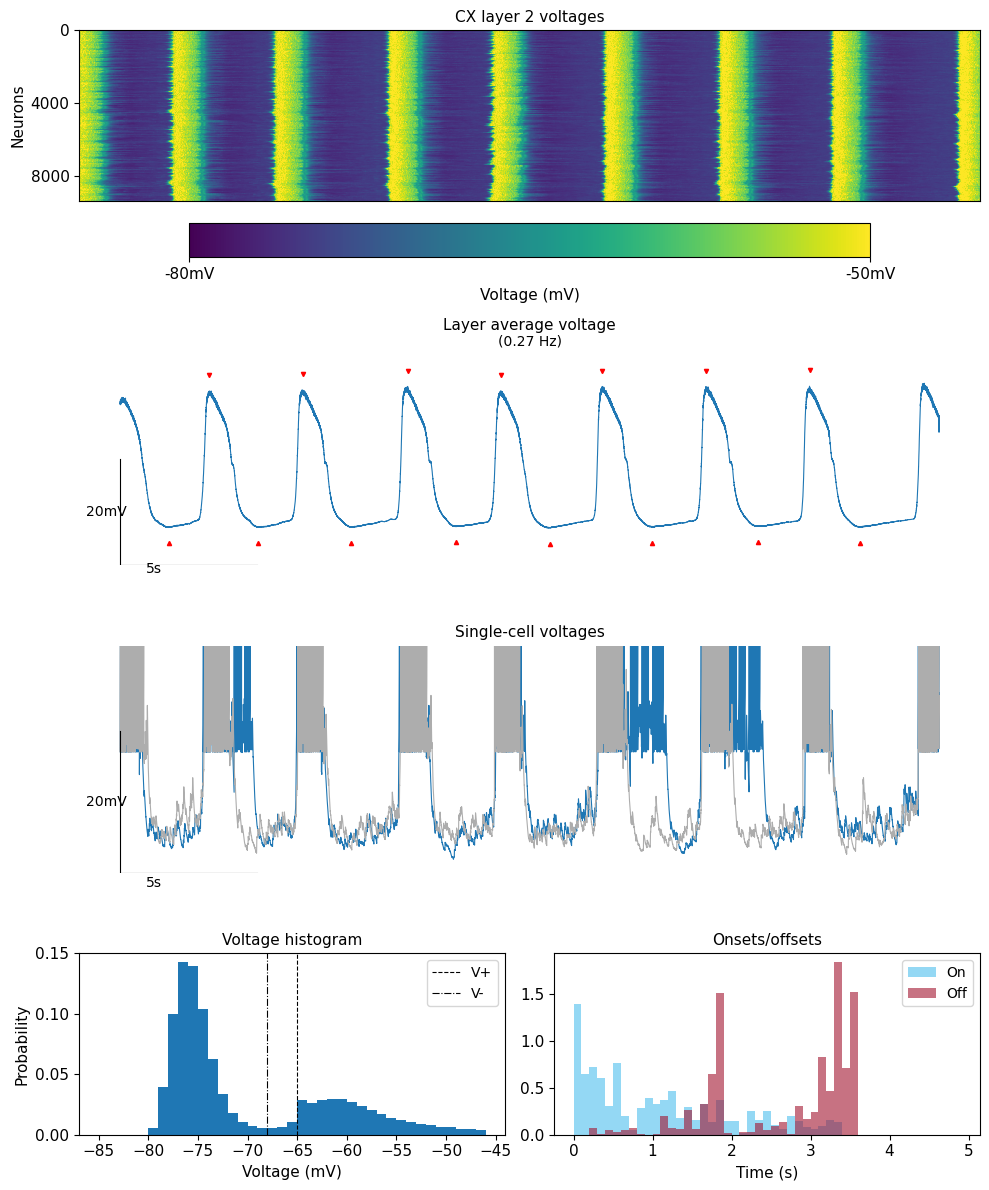

In [13]:
import matplotlib.gridspec as gridspec

print("Plotting summary figure...")
fig = plt.figure(figsize=(10, 12))
gs = gridspec.GridSpec(4, 2, height_ratios=[1, 1, 1, 0.8])
xticks_ms = np.arange(0, td+1, 5000)
xtick_labels = (xticks_ms / 1000).astype(int).astype(str)

# 1. Heatmap of CX L2 voltages
ax0 = fig.add_subplot(gs[0, :])
cmap = plt.get_cmap("viridis")
vmin, vmax = -80, -50

im = ax0.imshow(time_cx_nml, aspect='auto', cmap=cmap, vmin=vmin, vmax=vmax)
cb = fig.colorbar(im, ax=ax0, orientation='horizontal', pad=0.1)
cb.set_label('Voltage (mV)')
cb.set_ticks([vmin, vmax])
cb.set_ticklabels([f'{vmin}mV', f'{vmax}mV'])
ax0.set_title('CX layer 2 voltages')
ax0.set_ylabel('Neurons')
ax0.set_yticks(np.arange(0, n_nml, 4000))
#ax0.set_yticklabels((np.arange(0, n_nml, 4000) / 1000).astype(int).astype(str) + ['k'])
ax0.set_xticks([])

# 2. Average voltage with peaks/mins
ax1 = fig.add_subplot(gs[1, :])
ax1.plot(time_vector, time_cx_mean, label='Mean voltage')
ax1.plot(time_vector[peaks_idx], peaks + 3, 'vr', label='Peaks', markersize=3)
ax1.plot(time_vector[locs_mins], mins - 3, '^r', label='Mins', markersize=3)

ax1.set_title("Layer average voltage")
ax1.set_ylim([-83, -40])
ax1.axis('off')

# Add scales
scale_t = 5000  # ms
scale_y = 20    # mV
ax1.plot([0, scale_t], [-83, -83], 'k')
ax1.plot([0, 0], [-83, -63], 'k')
ax1.text(scale_t / 4, -84.5, f"{scale_t//1000}s", ha='center')
ax1.text(-scale_t * 0.25, -73, f"{scale_y}mV", va='center')

# Add SO stats
txt = f"({so_freq_mean:.2f} Hz)"
ax1.text(time_vector.max() / 2, -41.5, txt, ha='center')

# 3. Single cell voltages
ax2 = fig.add_subplot(gs[2, :])
c1, c2 = 1006, 928
ax2.plot(time_vector, time_cx[:,c1], label=f"Cell {c1}")
ax2.plot(time_vector, time_cx[:,c2], label=f"Cell {c2}", color=[0.68]*3)
ax2.set_ylim([-82, -50])
ax2.set_title("Single-cell voltages")
ax2.axis('off')
ax2.plot([0, scale_t], [-82, -82], 'k')
ax2.plot([0, 0], [-82, -62], 'k')
ax2.text(scale_t / 4, -84, f"{scale_t//1000}s", ha='center')
ax2.text(-scale_t * 0.25, -72, f"{scale_y}mV", va='center')

# 4. Voltage histogram
ax3 = fig.add_subplot(gs[3, 0])
flat_voltages = time_cx_nml.flatten()
flat_voltages = flat_voltages[~np.isnan(flat_voltages)]
h = ax3.hist(flat_voltages, bins=np.arange(-85, -45, 1), density=True)
ax3.axvline(thr_up, linestyle='--', color='k', label='V+')
ax3.axvline(thr_down, linestyle='-.', color='k', label='V-')
ax3.set_title("Voltage histogram")
ax3.set_xlabel("Voltage (mV)")
ax3.set_ylabel("Probability")
ax3.legend()

# 5. Onset/offset histograms
ax4 = fig.add_subplot(gs[3, 1])
onset_sec = onset_diffs[~np.isnan(onset_diffs)] * 0.001
offset_sec = offset_diffs[~np.isnan(offset_diffs)] * 0.001

h1 = ax4.hist(onset_sec, bins=np.arange(0, 5, 0.1), density=True, alpha=0.6, label='On', color='#4DBEEE')
h2 = ax4.hist(offset_sec, bins=np.arange(0, 5, 0.1), density=True, alpha=0.6, label='Off', color='#A2142F')

ax4.set_title("Onsets/offsets")
ax4.set_xlabel("Time (s)")
ax4.legend()

plt.tight_layout()
#plt.show()


In [14]:
import plotly.graph_objects as go
from ipywidgets import interact, IntSlider, Dropdown
import numpy as np

In [15]:
def plot_single_cell(cell_idx):
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=time_vector, y=time_cx_nml[cell_idx,:],
                             mode='lines',
                             name=f'Neuron {cell_idx}',
                             line=dict(width=1)))

    fig.update_layout(title=f"Neuron {cell_idx} Voltage Trace",
                      xaxis_title="Time (ms)",
                      yaxis_title="Voltage (mV)",
                      height=400)
    fig.show()

interact(plot_single_cell, cell_idx=IntSlider(min=0, max=time_cx.shape[0]-1, step=1, value=0));


interactive(children=(IntSlider(value=0, description='cell_idx', max=29999), Output()), _dom_classes=('widget-…

# Plot latency map

# Examine spatial evolution 

In [16]:
# Cell 1: Imports and Settings
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.tri as mtri
import ipywidgets as widgets
from IPython.display import display
import os
import scipy.io as sio
import csv

plt.rcParams.update({'font.size': 12, 'lines.linewidth': 0.8})

In [17]:
# Cell 2: Configuration
import_data = True  # True to import directly from sim output
load_data = False   # True to load pre-saved data



In [ ]:

pth = '/bazhlab/mnavaszu/meg/sims/stim/10mm5x/'
outfld = './videos/stim'
sim = '10mm5x'
folders = ['out_c1']
folder = folders[0]
video_name = f"{outfld}/{sim}_{folder}"


In [35]:
# Cell 3: Load Data and Surface
if import_data or load_data:
    # Load parcels to find medial wall
    with open('/Users/gkrishnan46/Downloads/whole-brain-SO-simulation/analysis/files/parcels.csv', 'r') as f:
        parc = np.array([int(line.strip()) for line in f])

    idx = np.arange(1, 10243)
    idx_ml = np.where(parc == 0)[0]
    idx_nml = np.setdiff1d(idx, idx_ml)

    # Load surface
    mObj = sio.loadmat('/Users/gkrishnan46/Downloads/whole-brain-SO-simulation/analysis/files/ico5_pial_surf_lh.mat')
    srf = mObj['srf']
    vertices = srf['pial'][0][0]['vertices'][0][0]
    faces = srf['pial'][0][0]['faces'][0][0] - 1  # MATLAB to Python indexing


In [20]:
tmax, ncol = time_cx.shape
data_nml = time_cx[:, idx_nml]
data_mean = np.mean(data_nml, axis=1)

In [22]:
# Cell 5: Prepare Data for Frames
win = 50
num_frames = tmax // win
data_chunked = time_cx.reshape((num_frames, win, ncol)).transpose(1, 0, 2)

ptimes = np.arange(0, tmax, win)
c1_idx = 1060
c1 = time_cx[:, c1_idx].copy()
c1[c1 > -50] = np.max(c1)  # Spike fix

v_lims = [-70, -55]
c_lims = [-80, 45]
xt = np.arange(0, tmax+1, 5000)
xtl = (xt / 1000).astype(str)

In [56]:
# %%
# Cell 1: Imports and Setup
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
import plotly.graph_objs as go
from ipywidgets import interact, IntSlider, VBox
import pandas as pd
from scipy.io import loadmat

# %%
# Cell 2: Load data
# Replace with your file paths
#data = np.loadtxt('time_cx.txt')[:, 1:]  # Assuming the first column is time
parc = np.loadtxt('/Users/gkrishnan46/Downloads/whole-brain-SO-simulation/analysis/files/parcels.csv')
srf = loadmat('/Users/gkrishnan46/Downloads/whole-brain-SO-simulation/analysis/files/ico5_pial_surf_lh.mat')['srf'][0, 0]

vertices = srf['pial'][0][0]['vertices']
faces = srf['pial'][0][0]['faces'] - 1  # MATLAB to Python indexing


# %%
# Cell 3: Preprocess
idx = np.arange(10242)
idx_ml = np.where(parc == 0)[0]
idx_nml = np.setdiff1d(idx, idx_ml)

data_nml = time_cx[:, idx_nml]
data_mean = np.mean(data_nml, axis=1)

win = 50
tmax = time_cx.shape[0]
ncol = time_cx.shape[1]
num_frames = tmax // win
data_chunked = time_cx.reshape((num_frames, win, ncol))

ptimes = np.arange(0, tmax, win)
c1_idx = 1060
c1 = time_cx[:, c1_idx]
c1[c1 > -50] = np.max(c1)  # Fix spikes

# %%
# Cell 4: Interactive Plotting Function
def plot_frame(i):
    i = int(i)
    voltages = data_chunked[i].mean(axis=0)
    
    # 3D surface
    mesh = go.Mesh3d(
        x=vertices[:, 0],
        y=vertices[:, 1],
        z=vertices[:, 2],
        i=faces[:, 0],
        j=faces[:, 1],
        k=faces[:, 2],
        intensity=voltages,
        colorscale='Viridis',
        colorbar=dict(title='Voltage (mV)'),
        showscale=True,
        lighting=dict(ambient=0.5, diffuse=1),
        lightposition=dict(x=0, y=0, z=100)
    )

    fig = go.Figure(data=[mesh])
    fig.update_layout(
        scene=dict(
            xaxis=dict(visible=False),
            yaxis=dict(visible=False),
            zaxis=dict(visible=False),
            aspectmode='data',
        ),
        margin=dict(l=0, r=0, t=0, b=0),
        title=f'Frame {i + 1}/{num_frames}'
    )
    fig.show()

    # Voltage traces
    fig2, axs = plt.subplots(2, 1, figsize=(12, 4), sharex=True)
    
    #axs[0].plot(ptimes[i:], data_mean[ptimes[i]:], 'k')
    #axs[0].plot(ptimes[:i], data_mean[ptimes[:i]], color='gray')
    axs[0].plot(np.arange(ptimes[i], tmax), data_mean[ptimes[i] :], "k")
    axs[0].plot(np.arange(0, ptimes[i]), data_mean[: ptimes[i]], color="gray")
    
    axs[0].axvline(ptimes[i], color='red', linewidth=2)
    axs[0].set_title("LFP Mean Voltage")
    axs[0].set_ylim([-70, -55])
    
#    axs[1].plot(ptimes[i:], c1[ptimes[i]:], 'k')
#    axs[1].plot(ptimes[:i], c1[ptimes[:i]], color='gray')
#    axs[1].axvline(ptimes[i], color='red', linewidth=2)

    axs[1].plot(np.arange(ptimes[i], tmax), c1[ptimes[i] :], "k")
    axs[1].plot(np.arange(0, ptimes[i]), c1[: ptimes[i]], color="gray")
    axs[1].axvline(ptimes[i], color="r")
    
    axs[1].set_title("Single-cell Voltage (Idx 1060)")
    axs[1].set_ylim([-80, 45])
    axs[1].set_xlabel("Time (ms)")

    plt.tight_layout()
    plt.show()

# %%
# Cell 5: Interactive Widget
interact(
    plot_frame,
    i=IntSlider(min=0, max=num_frames - 1, step=1, value=0, description="Frame")
);


interactive(children=(IntSlider(value=0, description='Frame', max=599), Output()), _dom_classes=('widget-inter…